In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import io
import matplotlib.pyplot as plt
import time
import os
import copy
from glob import glob
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score,roc_curve,confusion_matrix
warnings.simplefilter('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Subset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name())

BATCH_SIZE=2
EPOCH=50
LEARNING_RATE=0.001

cuda:0
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [13]:
import random
min_class_limit=2387
# Maximum number of samples in the train set
train_limit = None
# Maximum number of samples in the val set
val_limit = None

# Create the original datasets and dataloaders
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((500,250)),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((500,250)),
        transforms.ToTensor(),
    ])
}

data_dir = 'C:/Users/Zeynep Aygün/Desktop/teknofest_github/Mergen1-Teknofest/zeynep/data/ayrilmis'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train'])
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['val'])

# Find the number of classes
num_classes = len(train_dataset.classes)
class_names=train_dataset.classes

# Select 5000 images from each class
selected_indices = []
for i in range(num_classes):
    class_indices = [idx for idx, label in enumerate(train_dataset.targets) if label == i]
    class_indices = random.sample(class_indices, min(len(class_indices), min_class_limit))
    selected_indices.extend(class_indices)

# Select the specified number of samples from the train set
if train_limit is not None:
    selected_indices = selected_indices[:train_limit]

# Create new Subsets using the selected indices
train_subset = Subset(train_dataset, selected_indices)
val_subset = Subset(val_dataset, range(val_limit)) if val_limit is not None else val_dataset

# Create new DataLoaders for the Subsets
train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Update the dataset_sizes dictionary
dataset_sizes = {
        'train': len(train_subset),
        'val': len(val_subset)
    }
image_datasets = {
        'train': train_subset,
        'val': val_subset
    }
dataloaders={}
dataloaders["train"],dataloaders["val"]=train_dataloader,val_dataloader

dataset_sizes

{'train': 9548, 'val': 5398}

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
   
    plt.figure(figsize=(3,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [15]:
def train_model(model, criterion, optimizer, scheduler, name, num_epochs=25):
    min_class_limit=2387
    selected_indices = []
    for i in range(num_classes):
        class_indices = [idx for idx, label in enumerate(train_dataset.targets) if label == i]
        class_indices = random.sample(class_indices, min(len(class_indices), min_class_limit))
        selected_indices.extend(class_indices)

    # Select the specified number of samples from the train set
    if train_limit is not None:
        selected_indices = selected_indices[:train_limit]

    # Create new Subsets using the selected indices
    train_subset = Subset(train_dataset, selected_indices)
    val_subset = Subset(val_dataset, range(val_limit)) if val_limit is not None else val_dataset

    # Create new DataLoaders for the Subsets
    train_dataloader = torch.utils.data.DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_dataloader = torch.utils.data.DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

    dataloaders["train"],dataloaders["val"]=train_dataloader,val_dataloader
    
    try:
        os.mkdir(f'modelPerformance/{name}')
    except:
        print('Dosya var')

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            #epochs
            
            epoch=int(len(image_datasets[phase])/BATCH_SIZE)
            
            for _ in tqdm(range(epoch)):
                #Loading Data
                
                inputs, labels = next(iter(dataloaders[phase]))
                
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.to(device)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            
            #epoch_auc= running_auc/(dataset_sizes[phase]-error)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #AUC: {:.4f} , epoch_auc
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(        
                phase, epoch_loss, epoch_acc))
    
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model,'modelPerformance/{}/best_model_{:.4f}acc_{}epochs.h5'.format(name,epoch_acc,num_epochs))

                # Calculate and plot confusion matrix
                y_true = []
                y_pred = []

                model.eval()

                with torch.no_grad():
                    for inputs, labels in dataloaders['val']:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        y_true += labels.tolist()
                        y_pred += preds.tolist()

                cm = confusion_matrix(y_true, y_pred)
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                            xticklabels=class_names, yticklabels=class_names)
                plt.xlabel('Predicted labels')
                plt.ylabel('True labels')
                plt.title('Confusion matrix')
                plt.show()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    with open(f'modelPerformance/{name}/'+sorted(os.listdir(f'modelPerformance/{name}/'))[-1], 'rb') as f:
        buffer = io.BytesIO(f.read())
    model=torch.load(buffer)
    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [16]:
# A dictionary of models.

modeller={
    'kompozisyon_Densenet121_doğrukod':models.densenet121(pretrained=True)
}
try:
    os.mkdir('./modelPerformance')
except:
    print('Dosyalar var')

Dosyalar var


In [17]:
models.densenet121(pretrained=True).classifier


Linear(in_features=1024, out_features=1000, bias=True)

Dosya var
Epoch 1/50
----------


100%|██████████| 4774/4774 [14:58<00:00,  5.31it/s]


train Loss: 1.1723 Acc: 0.5132


100%|██████████| 2699/2699 [02:23<00:00, 18.76it/s]


val Loss: 0.7127 Acc: 0.6871


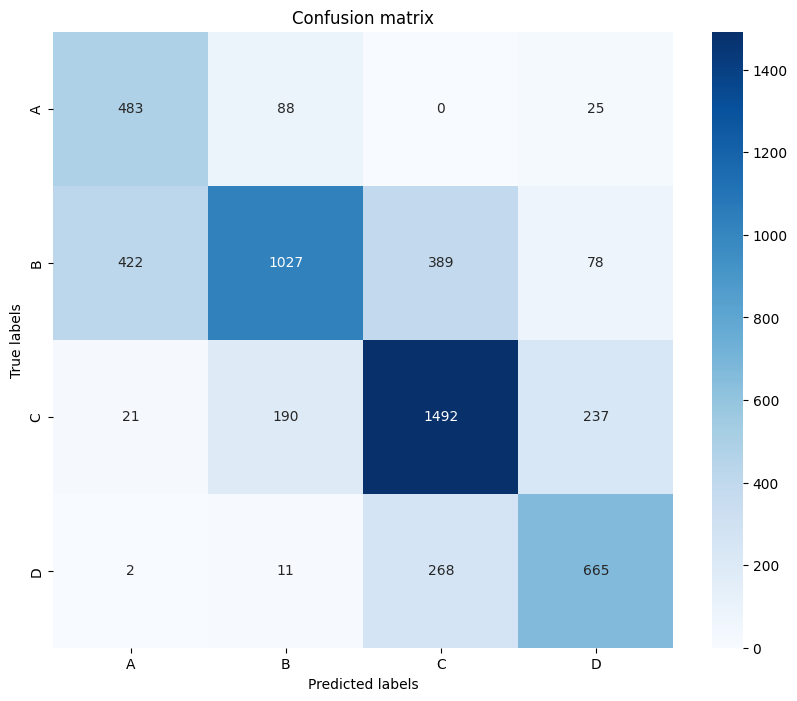


Epoch 2/50
----------


100%|██████████| 4774/4774 [13:57<00:00,  5.70it/s]


train Loss: 0.8059 Acc: 0.6459


100%|██████████| 2699/2699 [02:12<00:00, 20.39it/s]


val Loss: 0.6690 Acc: 0.7223


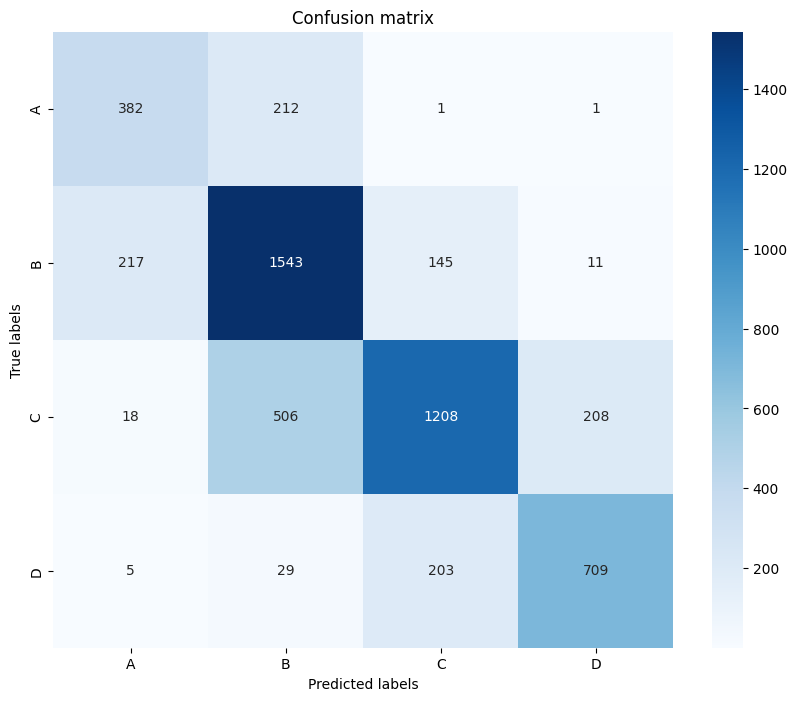


Epoch 3/50
----------


100%|██████████| 4774/4774 [13:40<00:00,  5.82it/s]


train Loss: 0.7130 Acc: 0.6860


100%|██████████| 2699/2699 [02:14<00:00, 20.06it/s]


val Loss: 0.7311 Acc: 0.6701

Epoch 4/50
----------


100%|██████████| 4774/4774 [13:06<00:00,  6.07it/s]


train Loss: 0.6612 Acc: 0.7139


100%|██████████| 2699/2699 [01:56<00:00, 23.24it/s]


val Loss: 0.7756 Acc: 0.6602

Epoch 5/50
----------


100%|██████████| 4774/4774 [12:27<00:00,  6.38it/s]


train Loss: 0.6212 Acc: 0.7401


100%|██████████| 2699/2699 [02:07<00:00, 21.25it/s]


val Loss: 0.7030 Acc: 0.6919

Epoch 6/50
----------


100%|██████████| 4774/4774 [12:48<00:00,  6.21it/s]


train Loss: 0.5306 Acc: 0.7730


100%|██████████| 2699/2699 [02:12<00:00, 20.38it/s]


val Loss: 0.7311 Acc: 0.6910

Epoch 7/50
----------


100%|██████████| 4774/4774 [12:47<00:00,  6.22it/s]


train Loss: 0.5338 Acc: 0.7773


100%|██████████| 2699/2699 [02:20<00:00, 19.24it/s]


val Loss: 0.7712 Acc: 0.6780

Epoch 8/50
----------


100%|██████████| 4774/4774 [13:00<00:00,  6.12it/s]


train Loss: 0.5203 Acc: 0.7825


100%|██████████| 2699/2699 [02:07<00:00, 21.10it/s]


val Loss: 0.7233 Acc: 0.6853

Epoch 9/50
----------


100%|██████████| 4774/4774 [12:47<00:00,  6.22it/s]


train Loss: 0.5309 Acc: 0.7769


100%|██████████| 2699/2699 [02:10<00:00, 20.74it/s]


val Loss: 0.7316 Acc: 0.6888

Epoch 10/50
----------


100%|██████████| 4774/4774 [13:12<00:00,  6.03it/s]


train Loss: 0.5217 Acc: 0.7784


100%|██████████| 2699/2699 [02:19<00:00, 19.34it/s]


val Loss: 0.7553 Acc: 0.6775

Epoch 11/50
----------


100%|██████████| 4774/4774 [12:53<00:00,  6.17it/s]


train Loss: 0.5244 Acc: 0.7739


100%|██████████| 2699/2699 [02:10<00:00, 20.71it/s]


val Loss: 0.6694 Acc: 0.7079

Epoch 12/50
----------


100%|██████████| 4774/4774 [12:45<00:00,  6.23it/s]


train Loss: 0.5301 Acc: 0.7805


100%|██████████| 2699/2699 [02:09<00:00, 20.83it/s]


val Loss: 0.7161 Acc: 0.6897

Epoch 13/50
----------


100%|██████████| 4774/4774 [13:06<00:00,  6.07it/s]


train Loss: 0.5232 Acc: 0.7811


100%|██████████| 2699/2699 [02:21<00:00, 19.08it/s]


val Loss: 0.7200 Acc: 0.6936

Epoch 14/50
----------


100%|██████████| 4774/4774 [12:51<00:00,  6.19it/s]


train Loss: 0.5254 Acc: 0.7788


100%|██████████| 2699/2699 [01:58<00:00, 22.85it/s]


val Loss: 0.7199 Acc: 0.6866

Epoch 15/50
----------


100%|██████████| 4774/4774 [12:12<00:00,  6.52it/s]


train Loss: 0.5490 Acc: 0.7659


100%|██████████| 2699/2699 [02:13<00:00, 20.16it/s]


val Loss: 0.7286 Acc: 0.6849

Epoch 16/50
----------


100%|██████████| 4774/4774 [12:40<00:00,  6.28it/s]


train Loss: 0.5280 Acc: 0.7748


100%|██████████| 2699/2699 [02:06<00:00, 21.28it/s]


val Loss: 0.7291 Acc: 0.6934

Epoch 17/50
----------


100%|██████████| 4774/4774 [12:19<00:00,  6.46it/s]


train Loss: 0.5312 Acc: 0.7767


100%|██████████| 2699/2699 [02:12<00:00, 20.34it/s]


val Loss: 0.6746 Acc: 0.7095

Epoch 18/50
----------


100%|██████████| 4774/4774 [12:16<00:00,  6.48it/s]


train Loss: 0.5087 Acc: 0.7853


100%|██████████| 2699/2699 [02:12<00:00, 20.38it/s]


val Loss: 0.7013 Acc: 0.6930

Epoch 19/50
----------


100%|██████████| 4774/4774 [12:16<00:00,  6.48it/s]


train Loss: 0.5169 Acc: 0.7831


100%|██████████| 2699/2699 [02:13<00:00, 20.25it/s]


val Loss: 0.7177 Acc: 0.6953

Epoch 20/50
----------


100%|██████████| 4774/4774 [12:17<00:00,  6.47it/s]


train Loss: 0.5211 Acc: 0.7807


100%|██████████| 2699/2699 [02:12<00:00, 20.34it/s]


val Loss: 0.7804 Acc: 0.6803

Epoch 21/50
----------


100%|██████████| 4774/4774 [12:16<00:00,  6.48it/s]


train Loss: 0.5226 Acc: 0.7779


100%|██████████| 2699/2699 [02:12<00:00, 20.36it/s]


val Loss: 0.7654 Acc: 0.6751

Epoch 22/50
----------


100%|██████████| 4774/4774 [12:18<00:00,  6.46it/s]


train Loss: 0.5312 Acc: 0.7827


100%|██████████| 2699/2699 [02:12<00:00, 20.38it/s]


val Loss: 0.7010 Acc: 0.7043

Epoch 23/50
----------


100%|██████████| 4774/4774 [12:16<00:00,  6.48it/s]


train Loss: 0.5239 Acc: 0.7793


100%|██████████| 2699/2699 [02:12<00:00, 20.34it/s]


val Loss: 0.7194 Acc: 0.6958

Epoch 24/50
----------


100%|██████████| 4774/4774 [12:16<00:00,  6.48it/s]


train Loss: 0.5295 Acc: 0.7768


100%|██████████| 2699/2699 [02:12<00:00, 20.35it/s]


val Loss: 0.7793 Acc: 0.6628

Epoch 25/50
----------


100%|██████████| 4774/4774 [12:18<00:00,  6.47it/s]


train Loss: 0.5216 Acc: 0.7789


100%|██████████| 2699/2699 [02:12<00:00, 20.34it/s]


val Loss: 0.7660 Acc: 0.6738

Epoch 26/50
----------


100%|██████████| 4774/4774 [12:18<00:00,  6.47it/s]


train Loss: 0.5285 Acc: 0.7761


100%|██████████| 2699/2699 [02:12<00:00, 20.33it/s]


val Loss: 0.7088 Acc: 0.6990

Epoch 27/50
----------


100%|██████████| 4774/4774 [12:18<00:00,  6.47it/s]


train Loss: 0.5347 Acc: 0.7784


100%|██████████| 2699/2699 [02:12<00:00, 20.32it/s]


val Loss: 0.7218 Acc: 0.6838

Epoch 28/50
----------


100%|██████████| 4774/4774 [12:17<00:00,  6.47it/s]


train Loss: 0.5289 Acc: 0.7734


100%|██████████| 2699/2699 [02:12<00:00, 20.36it/s]


val Loss: 0.7583 Acc: 0.6719

Epoch 29/50
----------


100%|██████████| 4774/4774 [12:19<00:00,  6.46it/s]


train Loss: 0.5216 Acc: 0.7813


100%|██████████| 2699/2699 [02:12<00:00, 20.31it/s]


val Loss: 0.7241 Acc: 0.6886

Epoch 30/50
----------


100%|██████████| 4774/4774 [12:17<00:00,  6.47it/s]


train Loss: 0.5172 Acc: 0.7810


100%|██████████| 2699/2699 [02:12<00:00, 20.37it/s]


val Loss: 0.7035 Acc: 0.7040

Epoch 31/50
----------


100%|██████████| 4774/4774 [12:17<00:00,  6.47it/s]


train Loss: 0.5276 Acc: 0.7748


100%|██████████| 2699/2699 [02:12<00:00, 20.31it/s]


val Loss: 0.7075 Acc: 0.6991

Epoch 32/50
----------


100%|██████████| 4774/4774 [12:17<00:00,  6.48it/s]


train Loss: 0.5319 Acc: 0.7711


100%|██████████| 2699/2699 [02:12<00:00, 20.41it/s]


val Loss: 0.7004 Acc: 0.7054

Epoch 33/50
----------


100%|██████████| 4774/4774 [12:18<00:00,  6.46it/s]


train Loss: 0.5399 Acc: 0.7682


100%|██████████| 2699/2699 [02:12<00:00, 20.33it/s]


val Loss: 0.6730 Acc: 0.7038

Epoch 34/50
----------


100%|██████████| 4774/4774 [12:17<00:00,  6.47it/s]


train Loss: 0.5264 Acc: 0.7793


100%|██████████| 2699/2699 [02:12<00:00, 20.34it/s]


val Loss: 0.7715 Acc: 0.6771

Epoch 35/50
----------


100%|██████████| 4774/4774 [12:17<00:00,  6.47it/s]


train Loss: 0.5323 Acc: 0.7731


100%|██████████| 2699/2699 [02:12<00:00, 20.39it/s]


val Loss: 0.7579 Acc: 0.6819

Epoch 36/50
----------


100%|██████████| 4774/4774 [12:14<00:00,  6.50it/s]


train Loss: 0.5462 Acc: 0.7682


100%|██████████| 2699/2699 [02:13<00:00, 20.28it/s]


val Loss: 0.7184 Acc: 0.6919

Epoch 37/50
----------


100%|██████████| 4774/4774 [12:16<00:00,  6.48it/s]


train Loss: 0.5284 Acc: 0.7763


100%|██████████| 2699/2699 [02:12<00:00, 20.34it/s]


val Loss: 0.7147 Acc: 0.6988

Epoch 38/50
----------


100%|██████████| 4774/4774 [12:20<00:00,  6.45it/s]


train Loss: 0.5288 Acc: 0.7805


100%|██████████| 2699/2699 [02:12<00:00, 20.36it/s]


val Loss: 0.7349 Acc: 0.6788

Epoch 39/50
----------


100%|██████████| 4774/4774 [12:27<00:00,  6.39it/s]


train Loss: 0.5213 Acc: 0.7792


100%|██████████| 2699/2699 [02:11<00:00, 20.58it/s]


val Loss: 0.7771 Acc: 0.6702

Epoch 40/50
----------


100%|██████████| 4774/4774 [12:15<00:00,  6.49it/s]


train Loss: 0.5319 Acc: 0.7759


100%|██████████| 2699/2699 [02:08<00:00, 20.96it/s]


val Loss: 0.7041 Acc: 0.6936

Epoch 41/50
----------


100%|██████████| 4774/4774 [12:25<00:00,  6.41it/s]


train Loss: 0.5133 Acc: 0.7855


100%|██████████| 2699/2699 [02:33<00:00, 17.63it/s]


val Loss: 0.7557 Acc: 0.6714

Epoch 42/50
----------


100%|██████████| 4774/4774 [13:22<00:00,  5.95it/s]


train Loss: 0.5306 Acc: 0.7731


100%|██████████| 2699/2699 [02:10<00:00, 20.69it/s]


val Loss: 0.7266 Acc: 0.6919

Epoch 43/50
----------


100%|██████████| 4774/4774 [12:42<00:00,  6.26it/s]


train Loss: 0.5397 Acc: 0.7735


100%|██████████| 2699/2699 [02:09<00:00, 20.76it/s]


val Loss: 0.7139 Acc: 0.6906

Epoch 44/50
----------


100%|██████████| 4774/4774 [12:47<00:00,  6.22it/s]


train Loss: 0.5179 Acc: 0.7804


100%|██████████| 2699/2699 [02:09<00:00, 20.91it/s]


val Loss: 0.7237 Acc: 0.6977

Epoch 45/50
----------


100%|██████████| 4774/4774 [13:05<00:00,  6.08it/s]


train Loss: 0.5195 Acc: 0.7814


100%|██████████| 2699/2699 [02:09<00:00, 20.87it/s]


val Loss: 0.7462 Acc: 0.6838

Epoch 46/50
----------


100%|██████████| 4774/4774 [12:57<00:00,  6.14it/s]


train Loss: 0.5195 Acc: 0.7813


100%|██████████| 2699/2699 [02:16<00:00, 19.76it/s]


val Loss: 0.7410 Acc: 0.6834

Epoch 47/50
----------


100%|██████████| 4774/4774 [12:18<00:00,  6.46it/s]


train Loss: 0.5321 Acc: 0.7722


100%|██████████| 2699/2699 [02:12<00:00, 20.39it/s]


val Loss: 0.7057 Acc: 0.6949

Epoch 48/50
----------


100%|██████████| 4774/4774 [12:44<00:00,  6.25it/s]


train Loss: 0.5329 Acc: 0.7770


100%|██████████| 2699/2699 [02:11<00:00, 20.50it/s]


val Loss: 0.7247 Acc: 0.6825

Epoch 49/50
----------


100%|██████████| 4774/4774 [12:19<00:00,  6.45it/s]


train Loss: 0.5093 Acc: 0.7836


100%|██████████| 2699/2699 [02:12<00:00, 20.33it/s]


val Loss: 0.7376 Acc: 0.6893

Epoch 50/50
----------


100%|██████████| 4774/4774 [12:21<00:00,  6.44it/s]


train Loss: 0.5267 Acc: 0.7761


100%|██████████| 2699/2699 [02:13<00:00, 20.19it/s]


val Loss: 0.7399 Acc: 0.6780

Training complete in 746m 15s
Best val Acc: 0.722305


In [18]:
for name,model in modeller.items(): 
    model_ft = model
    #model_ft=torch.load('C:/Users/Zeynep Aygün/Desktop/TEKNOFEST/yen/modelPerformance/vit/best_model_0.7244acc_20epochs.h5')
    
    model_ft.classifier=nn.Linear(in_features=1024, out_features=4, bias=True)
    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, momentum=0.9)
    #optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.0001)

    # TRAINING
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, name=name,
                            num_epochs=EPOCH)

In [19]:
import torch
import matplotlib
import numpy as np
import seaborn as sns
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

class get_metric():

    def get_accuracy_graph(epochs, train_acc, val_acc):  # draw validation and train accuracy graphs
        plt.plot(epochs, train_acc, color='#006BA4')
        plt.plot(epochs, val_acc, color='#FF800E')
        plt.grid(b=True, which='major', color='lightgray')
        plt.grid(b=True, which='minor', color='lightgray')
        plt.xticks(np.arange(0, 45, 5))
        plt.yticks(np.arange(0.5, 1, 0.05))
        plt.rcParams['figure.figsize'] = (8, 6)
        plt.rcParams['figure.dpi'] = 600
        plt.xlabel("Number of Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training Accuracy vs Validation Accuracy")
        plt.legend(['Training Acc.', 'Validation Acc.'], loc='lower right')
        plt.show()

    def get_loss_graph(epochs, train_losses, val_losses):  # draw validation and train loss graphs
        matplotlib.rcdefaults()
        plt.plot(epochs, train_losses, color='#006BA4')
        plt.plot(epochs, val_losses, color='#FF800E')
        plt.grid(b=True, which='major', color='lightgray')
        plt.grid(b=True, which='minor', color='lightgray')
        plt.xticks(np.arange(0, 45, 5))
        plt.yticks(np.arange(0, 1.2, 0.2))
        plt.rcParams['figure.dpi'] = 600
        plt.xlabel("Number of Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss vs Validation Loss")
        plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
        plt.show()

    def test_label_predictions(model, device, test_loader):  # calculate outputs on test dataset for get metrics
        model.eval()
        actuals = []
        predictions = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                model.to(device)
                output = model(data)
                prediction = output.argmax(dim=1, keepdim=True)
                actuals.extend(target.view_as(prediction))
                predictions.extend(prediction)
        return [i.item() for i in actuals], [i.item() for i in predictions]
    
    def test_label_predictions_el2(model_0,model_1,model_2,model_3, device, test_loader):
    
        actuals = []
        predictions = []

        with torch.no_grad():

            for data, target in test_loader:
                data, target = data.to(device), target.to(device)

                outputs_0 = model_0(data).cuda().cpu()
                _, predicted_0 =torch.max(outputs_0.data, 1) 

                outputs_1 = model_1(data)
                _, predicted_1 =torch.max(outputs_1.data, 1) 

                outputs_2 = model_2(data)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(data)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                size=final_pred.size()

                for i in range(0,(size[0])):   
                    a=0              
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            final_pred[i]=1

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1) :

                        a+=1   
                        if predicted_3[i].item()==0:
                            final_pred[i]=0 

                        if predicted_3[i].item()!=0:
                            final_pred[i]=1                    
                    if a==0:                   
                        final_pred[i]=predicted_2[i] 
                actuals.extend(target.view_as(final_pred))
                predictions.extend(final_pred)
        return [i.item() for i in actuals], [i.item() for i in predictions]

    def test_model(model ,device, test_loader):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print('Correct Prediction: {:d}  Total Images: {:d}'.format(correct, total))
        print('Test Accuracy = {:f}'.format(correct / total))
    
    def test_model_el2(model_0,model_1,model_2,model_3,device, test_loader):
        
        correct = 0
        total = 0

        with torch.no_grad():
            for data in test_loader:

                images, labels = data[0].to(device), data[1].to(device)

                outputs_0 = model_0(images)
                _, predicted_0 =torch.max(outputs_0.data, 1) 

                outputs_1 = model_1(images)
                _, predicted_1 =torch.max(outputs_1.data, 1) 

                outputs_2 = model_2(images)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(images)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                size=final_pred.size()

                for i in range(0,(size[0])):   
                    a=0              
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            final_pred[i]=1

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1):

                        a+=1

                        if predicted_3[i].item()==0:
                            final_pred[i]=0                        
                        if predicted_3[i].item()!=0:
                            final_pred[i]=1
                    if a==0:                   
                        final_pred[i]=predicted_2[i]

                total += labels.size(0)
                correct += (final_pred == labels).sum().item()
        print('Correct Prediction: {:d}  Total Images: {:d}'.format(correct, total))
        print('Test Accuracy = {:f}'.format(correct / total))

    def get_classification_report(truth, predict):  # create classification report for each class with scikit-learn library
        print('Classification Report :\n', classification_report(truth, predict))

    def get_confusion_matrix(actuals, predictions):  # create confusion matrix for each class with scikit-learn library
        matplotlib.rcdefaults()
        print('Confusion matrix:\n',confusion_matrix(actuals, predictions))
        cf_matrix=confusion_matrix(actuals, predictions)
        sns.heatmap(cf_matrix, annot=True,fmt='g', cmap='Blues')

    def get_cohen_kappa(actuals, predictions):  # get cohen kapa score for   determine model performance
        cps = cohen_kappa_score(actuals, predictions)
        print('Kappa Score of this model:\n', cps)

    def test_class_probabilities(model, device, test_loader, which_class):
        
        truths = []
        probabilities = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data).cuda().cpu()
                prediction = output.argmax(dim=1, keepdim=True)
                truths.extend(target.view_as(prediction) == which_class)
                probabilities.extend(np.exp(output[:, which_class]))
        return [i.item() for i in truths], [i.item() for i in probabilities]
    def test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, test_loader, which_class):
    
        truths = []
        probabilities = []

        with torch.no_grad():
            for data, target in test_loader:

                data, target = data.to(device), target.to(device)

                outputs_0 = model_0(data)
                _, predicted_0 =torch.max(outputs_0.data, 1) 

                outputs_1 = model_1(data)
                _, predicted_1 =torch.max(outputs_1.data, 1) 

                outputs_2 = model_2(data)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(data)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                out=outputs_1
                size=final_pred.size()

                for i in range(0,(size[0])):   
                    a=0              
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            #final_pred[i]=1
                            out[i]=outputs_1[i]

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                            out[i]=outputs_1[i]
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1):

                        a+=1

                        if predicted_3[i].item()==0:
                            #final_pred[i]=0
                            out[i]=outputs_3[i]

                        if predicted_3[i].item()!=0:
                            #final_pred[i]=1
                            out[i]=outputs_3[i]
                    if a==0:                   
                        #final_pred[i]=predicted_2[i]
                        out[i]=outputs_2[i]
                prediction = out.argmax(dim=1, keepdim=True)
                truths.extend(target.view_as(prediction) == which_class)
                probabilities.extend(np.exp(out.cuda().cpu()[:, which_class]))
        return [i.item() for i in truths], [i.item() for i in probabilities]
    
    def get_roc_curves_el2(model_0,model_1,model_2,model_3, device, data):  # draw Roc curves and calculate auc score for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        actuals, class_probabilities = get_metric.test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, data, 0)
        fpr[0], tpr[0], _ = roc_curve(actuals, class_probabilities)
        roc_auc[0] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, data, 1)
        fpr[1], tpr[1], _ = roc_curve(actuals, class_probabilities)
        roc_auc[1] = roc_auc_score(actuals, class_probabilities)

        print("Auc Score For Each Class: ", roc_auc)

        matplotlib.rcdefaults()
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(2), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
            label='ROC curve of class {0} (area = {1:0.4f})'
            ''.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()

    def get_roc_curves(model, device, data):  # draw Roc curves and calculate auc score for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 0)
        fpr[0], tpr[0], _ = roc_curve(actuals, class_probabilities)
        roc_auc[0] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 1)
        fpr[1], tpr[1], _ = roc_curve(actuals, class_probabilities)
        roc_auc[1] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 2)
        fpr[2], tpr[2], _ = roc_curve(actuals, class_probabilities)
        roc_auc[2] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 3)
        fpr[3], tpr[3], _ = roc_curve(actuals, class_probabilities)
        roc_auc[3] = roc_auc_score(actuals, class_probabilities)

        print("Auc Score For Each Class: ", roc_auc)

        matplotlib.rcdefaults()
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(2), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
                label='ROC curve of class {0} (area = {1:0.4f})'
                    ''.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()



densenet121
-----------------
F1 Score: 0.6272577996715928 0.7337137422729435 0.6908778953388618 0.7562666666666666
Recall: 0.6409395973154363 0.8053235908141962 0.622680412371134 0.7494714587737844
Precision: 0.6141479099678456 0.6737991266375546 0.7758509955041747 0.7631862217438106


Classification Report :
               precision    recall  f1-score   support

           0       0.61      0.64      0.63       596
           1       0.67      0.81      0.73      1916
           2       0.78      0.62      0.69      1940
           3       0.76      0.75      0.76       946

    accuracy                           0.71      5398
   macro avg       0.71      0.70      0.70      5398
weighted avg       0.72      0.71      0.71      5398

Correct Prediction: 3842  Total Images: 5398
Test Accuracy = 0.711745
Kappa Score of this model:
 0.5898912914724629


Confusion matrix:
 [[ 382  212    1    1]
 [ 217 1543  145   11]
 [  18  506 1208  208]
 [   5   29  203  709]]




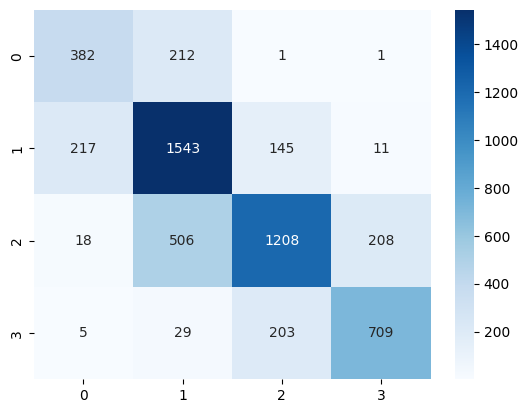

In [21]:
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score,roc_curve,confusion_matrix,precision_score,recall_score
print('\n'+'densenet121'+'\n-----------------')  
model_ft=torch.load('C:/Users/Zeynep Aygün/Desktop/teknofest_github/Mergen1-Teknofest/zeynep/modelPerformance/kompozisyon_Densenet121_doğrukod/best_model_0.7223acc_50epochs.h5')
phase='val'
actuals, predictions = get_metric.test_label_predictions(model_ft, device, dataloaders[phase])
f1=f1_score(predictions,actuals,average=None)
recall=recall_score(actuals,predictions,average=None)
precision=precision_score(actuals,predictions,average=None)
print(f'F1 Score: {f1[0]} {f1[1]} {f1[2]} {f1[3]}')
print(f'Recall: {recall[0]} {recall[1]} {recall[2]} {recall[3]}') 
print(f'Precision: {precision[0]} {precision[1]} {precision[2]} {precision[3]}')
print('\n')
get_metric.get_classification_report(actuals, predictions)
get_metric.test_model(model_ft,device,dataloaders[phase])
get_metric.get_cohen_kappa(actuals, predictions)
print('\n')
get_metric.get_confusion_matrix(actuals, predictions)
print('\n')
#get_metric.get_roc_curves(model_ft, device,  dataloaders[phase])